In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
import glob
import utm

from rasterio.plot import show
from shapely.geometry import Point
from pyproj import Transformer

In [ ]:
# --- Step 1: Load the georeferenced TIFF ---
tif_path = "path/to/your/orthomosaic.tif"
with rasterio.open(tif_path) as src:
    ortho_bounds = src.bounds  # Get bounding box
    ortho_crs = src.crs  # Get projection
    ortho_image = src.read()  # Read raster data

# --- Step 2: Load CSV with movement data ---
csv_path = "path/to/your/movement.csv"
df = pd.read_csv(csv_path)

# Ensure CSV contains columns ['latitude', 'longitude', 'time']
if not {'latitude', 'longitude', 'time'}.issubset(df.columns):
    raise ValueError("CSV must contain 'latitude', 'longitude', and 'time' columns")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# --- Step 3: Ensure CRS Consistency ---
if gdf.crs != ortho_crs:
    raise ValueError(f"CRS mismatch! Orthomosaic CRS: {ortho_crs}, Movement Data CRS: {gdf.crs}")
    
# Extract x, y coordinates (since they are already in the correct CRS)
gdf["x"], gdf["y"] = gdf.geometry.x, gdf.geometry.y


# --- Step 4: Plot Orthomosaic and Movement Paths ---
fig, ax = plt.subplots(figsize=(10, 10))
show(ortho_image, transform=src.transform, ax=ax)  # Plot the orthomosaic

# Scatter and connect points
sc = ax.scatter(gdf["x"], gdf["y"], c=pd.to_datetime(gdf["time"]).astype(int), cmap='viridis', s=10, label="Movement")
ax.plot(gdf["x"], gdf["y"], linestyle='-', color='red', alpha=0.7)

# Add colorbar for time representation
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Time (Epoch)")

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Movement Overlay on Orthomosaic")
plt.legend()
plt.show()


In [2]:
# Load dataset with longitude, latitude and altitude for all marked territories from the orthomosaic
map_coordinates = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Metashape/TalChhapar/output/territories_xyz.txt', header=None)
map_coordinates = map_coordinates.iloc[:,:4]
map_coordinates.columns = ['Point', 'Longitude', 'Latitude', 'Altitude']
map_coordinates.head()

,Point,Longitude,Latitude,Altitude
0,1,74.436945,27.800021,287.9558
1,2,74.436766,27.800038,288.3593
2,3,74.436602,27.799934,288.8230
3,4,74.436794,27.799810,288.5657
4,5,74.437163,27.799771,287.6457


In [4]:
DATE = ['20230302']#, '20230305']
SESSION = ['SM_Lek1']#, 'SE_Lek1']
DRONE = ['P1D1', 'P2D3', 'P3D5']#, 'P2D4', 'P3D5', 'P3D6']

files_directory = '/Volumes/EAS_shared/blackbuck/working/processed/Field_Recording_2023/TestRegistration'

### Compute georeferencing error

In [4]:
idx = 0
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            print(date, session, drone)
            
            internal_path = files_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_3D_territories.csv')

            for file in sorted(files):
                tmp = pd.read_csv(file)
                tmp['drone'] = drone
                
                if idx != 0:
                    df_terr = pd.concat((df_terr, tmp), axis=0)
                else:
                    df_terr = tmp
                
                idx += 1

20230302 SM_Lek1 P1D1
20230302 SM_Lek1 P2D3
20230302 SM_Lek1 P3D5


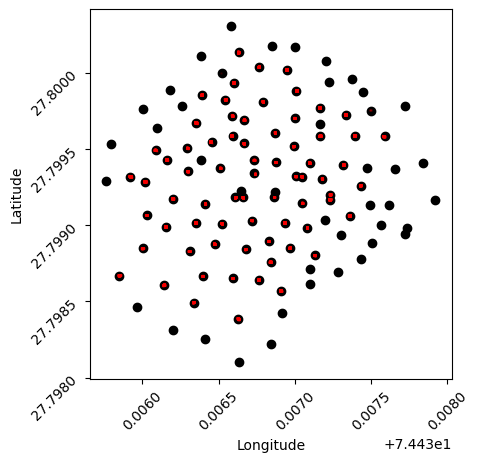

In [11]:
# Create the scatter plots
plt.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black')
plt.scatter(df_terr['latitude'], df_terr['longitude'], c='red', s=1, alpha=0.1)

# Maintain equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and legends
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [12]:
# Merge dataframes and convert coordinates to UTM
df_terr = df_terr.merge(map_coordinates, on='Point', how='left')

utm_map = utm.from_latlon(df_terr.loc[:,'Latitude'].values, df_terr.loc[:,'Longitude'].values)
utm_frame = utm.from_latlon(df_terr.loc[:,'longitude'].values, df_terr.loc[:,'latitude'].values)

In [13]:
# Compute error
df_terr['Easting'] = utm_map[0]
df_terr['Northing'] = utm_map[1]
df_terr['EastingComputed'] = utm_frame[0]
df_terr['NorthingComputed'] = utm_frame[1]

df_terr['Distance'] = np.sqrt((df_terr['Easting'] - df_terr['EastingComputed'])**2 + (df_terr['Northing'] - df_terr['NorthingComputed'])**2)

print(f"Mean error: {df_terr['Distance'].mean().round(2)}m")
print(f"{round(len(df_terr.loc[df_terr['Distance'] < 1])/len(df_terr)*100, 2)}% territories have an error of <1m")

Mean error: 0.4m
99.28% territories have an error of <1m


### Plot georeferenced trajectories

In [5]:
idx = 0
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            print(date, session, drone)
            
            internal_path = files_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_3D_trajectories.csv')

            for file in sorted(files):
                tmp = pd.read_csv(file)
                tmp['drone'] = drone
                
                if idx != 0:
                    df_traj = pd.concat((df_traj, tmp), axis=0)
                else:
                    df_traj = tmp
                
                idx += 1

20230302 SM_Lek1 P1D1
20230302 SM_Lek1 P2D3
20230302 SM_Lek1 P3D5


In [6]:
for idx, ID in enumerate(np.unique(df_traj['drone'])):
    df_traj.loc[df_traj['drone'] == ID, 'drone_id'] = idx

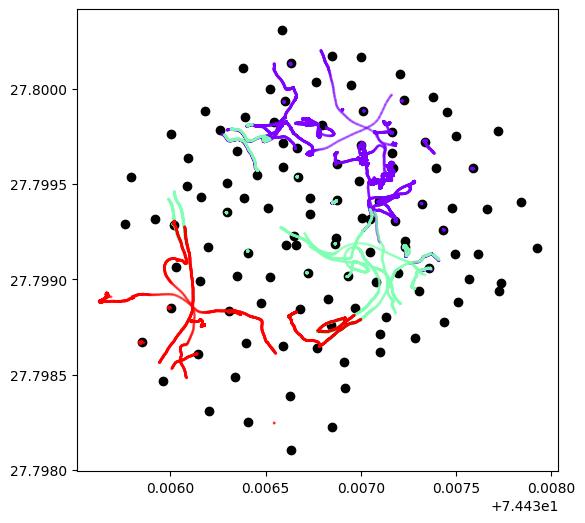

In [7]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(9, 6))  # You can adjust these values as needed

# Create the scatter plots
plt.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black')
plt.scatter(df_traj['x'], df_traj['y'], c=df_traj['drone_id'], cmap='rainbow', s=1, alpha=0.1)

# Maintain equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()